In [23]:
import math
import torch
from torch import nn 
from d2l import torch as d2l

In [24]:
#多头注意力
#选择缩放点击注意力作为每一个注意力头
#@save
#@save
class MultiHeadAttention(nn.Module):
    """多头注意力"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 num_heads, dropout, bias=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = d2l.DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        # queries，keys，values的形状:
        # (batch_size，查询或者“键－值”对的个数，num_hiddens)
        # valid_lens　的形状:
        # (batch_size，)或(batch_size，查询的个数)
        # 经过变换后，输出的queries，keys，values　的形状:
        # (batch_size*num_heads，查询或者“键－值”对的个数，
        # num_hiddens/num_heads)
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)

        if valid_lens is not None:
            # 在轴0，将第一项（标量或者矢量）复制num_heads次，
            # 然后如此复制第二项，然后诸如此类。
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0)

        # output的形状:(batch_size*num_heads，查询的个数，
        # num_hiddens/num_heads)
        output = self.attention(queries, keys, values, valid_lens)

        # output_concat的形状:(batch_size，查询的个数，num_hiddens)
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)

In [25]:
#@save
def transpose_qkv(X, num_heads):
    """为了多注意力头的并行计算而变换形状"""
    # 输入X的形状:(batch_size，查询或者“键－值”对的个数，num_hiddens)
    # 输出X的形状:(batch_size，查询或者“键－值”对的个数，num_heads，
    # num_hiddens/num_heads)
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)

    # 输出X的形状:(batch_size，num_heads，查询或者“键－值”对的个数,
    # num_hiddens/num_heads)
    X = X.permute(0, 2, 1, 3)

    # 最终输出的形状:(batch_size*num_heads,查询或者“键－值”对的个数,
    # num_hiddens/num_heads)
    return X.reshape(-1, X.shape[2], X.shape[3])


#@save
def transpose_output(X, num_heads):
    """逆转transpose_qkv函数的操作"""
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

In [26]:
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens,
                               num_hiddens, num_heads, 0.5)
attention.eval()

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [27]:
batch_size, num_queries = 2, 4
num_kvpairs, valid_lens =  6, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))
attention(X, Y, Y, valid_lens).shape

torch.Size([2, 4, 100])

In [28]:
class PositionWiseFFN(nn.Module):
    """基于位置的前馈网络"""
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs,
                 **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

In [31]:
ffn = PositionWiseFFN(4, 4, 8)
ffn


PositionWiseFFN(
  (dense1): Linear(in_features=4, out_features=4, bias=True)
  (relu): ReLU()
  (dense2): Linear(in_features=4, out_features=8, bias=True)
)

In [33]:
ffn.eval()
ffn(torch.ones((2, 3, 4)))

tensor([[[-0.0491, -0.7420,  0.0606,  0.0936,  0.1388, -0.2726, -0.3462,
          -0.3101],
         [-0.0491, -0.7420,  0.0606,  0.0936,  0.1388, -0.2726, -0.3462,
          -0.3101],
         [-0.0491, -0.7420,  0.0606,  0.0936,  0.1388, -0.2726, -0.3462,
          -0.3101]],

        [[-0.0491, -0.7420,  0.0606,  0.0936,  0.1388, -0.2726, -0.3462,
          -0.3101],
         [-0.0491, -0.7420,  0.0606,  0.0936,  0.1388, -0.2726, -0.3462,
          -0.3101],
         [-0.0491, -0.7420,  0.0606,  0.0936,  0.1388, -0.2726, -0.3462,
          -0.3101]]], grad_fn=<ViewBackward0>)

In [35]:
ln = nn.LayerNorm(2)
bn = nn.BatchNorm1d(2)
X = torch.tensor([[1, 2], [2, 3]], dtype=torch.float32)
# 在训练模式下计算X的均值和方差
X

tensor([[1., 2.],
        [2., 3.]])

In [36]:
print('layer norm:', ln(X), '\nbatch norm:', bn(X))

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


In [12]:
#@save
class AddNorm(nn.Module):
    """残差连接后进行层规范化"""
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

In [13]:
add_norm = AddNorm([3, 4], 0.5)
add_norm.eval()
add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4))).shape

torch.Size([2, 3, 4])

In [14]:
#@save
class EncoderBlock(nn.Module):
    """transformer编码器块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout,
            use_bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(
            ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

In [15]:
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
encoder_blk.eval()
encoder_blk(X, valid_lens).shape

torch.Size([2, 100, 24])

In [16]:
#@save
class TransformerEncoder(d2l.Encoder):
    """transformer编码器"""
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                EncoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, use_bias))

    def forward(self, X, valid_lens, *args):
        # 因为位置编码值在-1和1之间，
        # 因此嵌入值乘以嵌入维度的平方根进行缩放，
        # 然后再与位置编码相加。
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        return X

In [17]:
encoder = TransformerEncoder(
    200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
encoder.eval()
encoder(torch.ones((2, 100), dtype=torch.long), valid_lens).shape

torch.Size([2, 100, 24])

In [18]:
class DecoderBlock(nn.Module):
    """解码器中第i个块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens,
                                   num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # 训练阶段，输出序列的所有词元都在同一时间处理，
        # 因此state[2][self.i]初始化为None。
        # 预测阶段，输出序列是通过词元一个接着一个解码的，
        # 因此state[2][self.i]包含着直到当前时间步第i个块解码的输出表示
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            # dec_valid_lens的开头:(batch_size,num_steps),
            # 其中每一行是[1,2,...,num_steps]
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None

        # 自注意力
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # 编码器－解码器注意力。
        # enc_outputs的开头:(batch_size,num_steps,num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

In [19]:
decoder_blk = DecoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 0)
decoder_blk.eval()
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
decoder_blk(X, state)[0].shape

torch.Size([2, 100, 24])

In [21]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                DecoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, i))
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # 解码器自注意力权重
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            # “编码器－解码器”自注意力权重
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

loss 0.031, 4582.9 tokens/sec on cuda:0


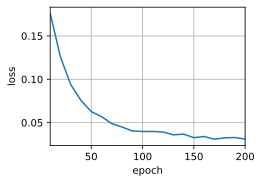

In [22]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
decoder = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [ ]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')